# Import Packages

In [1]:
import pandas as pd
import numpy as np
from pprint import pprint
import re
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import nltk
#spacy for lemmatization
import spacy
#Plotting Tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)


# Prepare Stopwords

In [2]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

# Import Newsgroups Data

In [3]:
# Import Dataset
df = pd.read_json('newsgroups.json')
print(df.target_names.unique())
print(df.target.unique())
df.head()


['rec.autos' 'comp.sys.mac.hardware' 'comp.graphics' 'sci.space'
 'talk.politics.guns' 'sci.med' 'comp.sys.ibm.pc.hardware'
 'comp.os.ms-windows.misc' 'rec.motorcycles' 'talk.religion.misc'
 'misc.forsale' 'alt.atheism' 'sci.electronics' 'comp.windows.x'
 'rec.sport.hockey' 'rec.sport.baseball' 'soc.religion.christian'
 'talk.politics.mideast' 'talk.politics.misc' 'sci.crypt']
[ 7  4  1 14 16 13  3  2  8 19  6  0 12  5 10  9 15 17 18 11]


,content,target,target_names
0,From: lerxst@wam.umd.edu (where's my thing)\nS...,7,rec.autos
1,From: guykuo@carson.u.washington.edu (Guy Kuo)...,4,comp.sys.mac.hardware
2,From: twillis@ec.ecn.purdue.edu (Thomas E Will...,4,comp.sys.mac.hardware
3,From: jgreen@amber (Joe Green)\nSubject: Re: W...,1,comp.graphics
4,From: jcm@head-cfa.harvard.edu (Jonathan McDow...,14,sci.space


In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.25, random_state=25)

# content Length by target Distribution for train data

In [6]:
train['content_len'] = train['content'].apply(lambda x: len(x.split()))

D:\anaconda3\envs\lda\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [7]:
train.head()

,content,target,target_names,content_len
2490,From: carlos@beowulf.Jpl.Nasa.Gov (Carlos Carr...,18,talk.politics.misc,164
1213,From: maynard@ramsey.cs.laurentian.ca (Roger M...,10,rec.sport.hockey,68
4472,From: fang@en.ecn.purdue.edu (Wen-Cheng Fang)\...,6,misc.forsale,131
1161,Distribution: world\nFrom: David_A._Schnider@b...,4,comp.sys.mac.hardware,77
11214,From: maynard@ramsey.cs.laurentian.ca (Roger M...,10,rec.sport.hockey,855


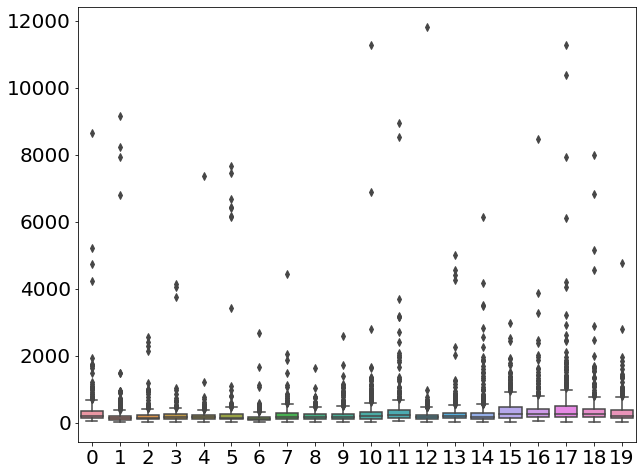

In [8]:
import seaborn as sns

plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 20})
sns.boxplot(x = 'target', y = 'content_len', data = train)
plt.ylabel('')
plt.xlabel('');

# Num content by target Count Distribution  

D:\anaconda3\envs\lda\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


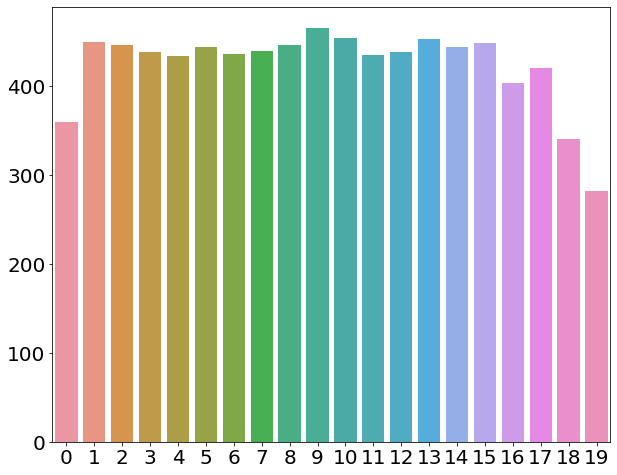

In [9]:
plt.figure(figsize=(10,8))
plt.rcParams.update({'font.size': 20})
sns.countplot('target', data = train)
plt.ylabel('')
plt.xlabel('');

# Remove emails and newline characters

In [10]:
# Convert to list
train_data = train.content.values.tolist()
test_data = test.content.values.tolist()

# Remove Emails
train_data = [re.sub('\S*@\S*\s?', '', sent) for sent in train_data]
test_data = [re.sub('\S*@\S*\s?', '', sent) for sent in test_data]

# Remove new line characters
train_data = [re.sub('\s+', ' ', sent) for sent in train_data]
test_data = [re.sub('\s+', ' ', sent) for sent in test_data]

# Remove distracting single quotes
train_data = [re.sub("\'", "", sent) for sent in train_data]
test_data = [re.sub("\'", "", sent) for sent in test_data]

pprint(train_data[:1])
pprint(test_data[:1])

['From: (Carlos Carrion) Subject: Re: The Role of the National News Media in '
 'Inflaming Passions Organization: Jet Propulsion Laboratory, Pasadena, CA '
 'Lines: 20 Distribution: ca NNTP-Posting-Host: beowulf.jpl.nasa.gov In '
 'article (Michael A. Thomas) writes: >In article (Carlos Carrion) writes: >> '
 'I have come to the conclusion that the TV stations here in LA >> WANT a riot '
 'to happen when the verdict comes in. > > Why is this surprising? Then the '
 '_Times_ can get a few more >Pulitzers the same way they did last year. I '
 'suppose ALL media want something to happen, otherwise what would they '
 'report: thats their job. (duhhh to me!) But its not so much surprising that '
 'they want a riot as it is amazing how they carry that desire across in not '
 'so subtle ways (at least to me...) carlos. "I as much as any other man am in '
 'favor of having the superior position assigned to the white race" - Abraham '
 'Lincoln ...ames!elroy!jpl-devvax!{beowulf|pituco}!carlos '

# Tokenize words and Clean-up text

In [11]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

train_data_words = list(sent_to_words(train_data))
test_data_words = list(sent_to_words(test_data))

print(train_data_words[:1])
print(test_data_words[:1])

[['from', 'carlos', 'carrion', 'subject', 're', 'the', 'role', 'of', 'the', 'national', 'news', 'media', 'in', 'inflaming', 'passions', 'organization', 'jet', 'propulsion', 'laboratory', 'pasadena', 'ca', 'lines', 'distribution', 'ca', 'nntp', 'posting', 'host', 'beowulf', 'jpl', 'nasa', 'gov', 'in', 'article', 'michael', 'thomas', 'writes', 'in', 'article', 'carlos', 'carrion', 'writes', 'have', 'come', 'to', 'the', 'conclusion', 'that', 'the', 'tv', 'stations', 'here', 'in', 'la', 'want', 'riot', 'to', 'happen', 'when', 'the', 'verdict', 'comes', 'in', 'why', 'is', 'this', 'surprising', 'then', 'the', 'can', 'get', 'few', 'more', 'pulitzers', 'the', 'same', 'way', 'they', 'did', 'last', 'year', 'suppose', 'all', 'media', 'want', 'something', 'to', 'happen', 'otherwise', 'what', 'would', 'they', 'report', 'thats', 'their', 'job', 'duhhh', 'to', 'me', 'but', 'its', 'not', 'so', 'much', 'surprising', 'that', 'they', 'want', 'riot', 'as', 'it', 'is', 'amazing', 'how', 'they', 'carry', 't

# Creating Bigram and Trigram Models

In [12]:
# Build the bigram and trigram models
train_bigram = gensim.models.Phrases(train_data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
test_bigram = gensim.models.Phrases(test_data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
train_trigram = gensim.models.Phrases(train_bigram[train_data_words], threshold=100)  
test_trigram = gensim.models.Phrases(test_bigram[test_data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
train_bigram_mod = gensim.models.phrases.Phraser(train_bigram)
test_bigram_mod = gensim.models.phrases.Phraser(test_bigram)
train_trigram_mod = gensim.models.phrases.Phraser(train_trigram)
test_trigram_mod = gensim.models.phrases.Phraser(test_trigram)

# See trigram example
print(train_trigram_mod[train_bigram_mod[train_data_words[0]]])
print(test_trigram_mod[test_bigram_mod[test_data_words[0]]])

['from', 'carlos_carrion', 'subject', 're', 'the', 'role', 'of', 'the', 'national', 'news', 'media', 'in', 'inflaming_passions', 'organization', 'jet_propulsion_laboratory_pasadena', 'ca', 'lines', 'distribution', 'ca', 'nntp_posting_host', 'beowulf', 'jpl_nasa_gov', 'in', 'article', 'michael', 'thomas', 'writes', 'in', 'article', 'carlos_carrion', 'writes', 'have', 'come', 'to', 'the', 'conclusion', 'that', 'the', 'tv_stations', 'here', 'in', 'la', 'want', 'riot', 'to', 'happen', 'when', 'the', 'verdict', 'comes', 'in', 'why', 'is', 'this', 'surprising', 'then', 'the', 'can', 'get', 'few', 'more', 'pulitzers', 'the', 'same', 'way', 'they', 'did', 'last_year', 'suppose', 'all', 'media', 'want', 'something', 'to', 'happen', 'otherwise', 'what', 'would', 'they', 'report', 'thats', 'their', 'job', 'duhhh', 'to', 'me', 'but', 'its', 'not', 'so', 'much', 'surprising', 'that', 'they', 'want', 'riot', 'as', 'it', 'is', 'amazing', 'how', 'they', 'carry', 'that', 'desire', 'across', 'in', 'not'

# Remove Stopwords, Make Bigrams and Lemmatize

In [13]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [train_bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [train_trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [14]:
# Remove Stop Words
train_data_words_nostops = remove_stopwords(train_data_words)
test_data_words_nostops = remove_stopwords(test_data_words)

# Form Bigrams
train_data_words_bigrams = make_bigrams(train_data_words_nostops)
test_data_words_bigrams = make_bigrams(test_data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
train_data_lemmatized = lemmatization(train_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])
test_data_lemmatized = lemmatization(test_data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(train_data_lemmatized[:1])
print(test_data_lemmatized[:1])

[['organization', 'ca', 'line', 'distribution', 'ca', 'nntp_poste', 'host', 'beowulf', 'write', 'article', 'write', 'come', 'conclusion', 'tv_station', 'want', 'riot', 'happen', 'verdict', 'come', 'surprising', 'pulitzer', 'way', 'last', 'year', 'suppose', 'medium', 'want', 'happen', 'otherwise', 'would', 'report', 'job', 'duhhh', 'much', 'surprising', 'want', 'riot', 'amazing', 'carry', 'desire', 'subtle', 'way', 'least', 'much', 'man', 'favor', 'superior', 'position', 'assign', 'white', 'race']]
[['proposal', 'nntp_poste', 'host', 'line', 'write', 'center', 'policy_research', 'cpr', 'proposal', 'peace', 'fund', 'establish', 'would', 'disburse', 'grant', 'child', 'bear', 'couple', 'partner', 'israeli', 'entitle', 'couple', 'prove', 'partner', 'possesse', 'entitle', 'israeli', 'citizenship', 'law', 'return', 'partner', 'bear', 'area', 'current', 'isreali', 'control', 'entitle', 'citizenship', 'law', 'return', 'first', 'child', 'grant', 'amount', 'second', 'third', 'child', 'child', 'su

# Create the Dictionary and Corpus needed for Topic Modeling

In [15]:
# Create Dictionary
train_id2word = corpora.Dictionary(train_data_lemmatized)
test_id2word = corpora.Dictionary(test_data_lemmatized)

# Create Corpus
train_texts = train_data_lemmatized
test_texts = test_data_lemmatized

# Term Document Frequency
train_corpus = [train_id2word.doc2bow(text) for text in train_texts]
test_corpus = [test_id2word.doc2bow(text) for text in test_texts]

# View
print(train_corpus[:1])
print(test_corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 2), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 2), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 2), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 2), (29, 1), (30, 1), (31, 1), (32, 2), (33, 1), (34, 1), (35, 3), (36, 2), (37, 1), (38, 1), (39, 2), (40, 1)]]
[[(0, 2), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 1), (7, 1), (8, 7), (9, 2), (10, 1), (11, 1), (12, 1), (13, 1), (14, 2), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 3), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 2), (28, 3), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 2), (35, 1), (36, 1), (37, 2), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 2), (44, 1), (45, 1), (46, 1), (47, 1), (48, 1), (49, 3), (50, 1), (51, 2), (52, 1), (53, 1), (54, 1), (55, 1), (56, 1), (57, 5), (58, 1), (59, 2), (60, 1), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 2), (68, 1)]]


In [16]:
train_id2word[60]
test_id2word[60]

'role'

In [17]:
# Human readable format of corpus (term-frequency)
[[(train_id2word[id], freq) for id, freq in cp] for cp in train_corpus[:1]]


[[('amazing', 1),
  ('article', 1),
  ('assign', 1),
  ('beowulf', 1),
  ('ca', 2),
  ('carry', 1),
  ('come', 2),
  ('conclusion', 1),
  ('desire', 1),
  ('distribution', 1),
  ('duhhh', 1),
  ('favor', 1),
  ('happen', 2),
  ('host', 1),
  ('job', 1),
  ('last', 1),
  ('least', 1),
  ('line', 1),
  ('man', 1),
  ('medium', 1),
  ('much', 2),
  ('nntp_poste', 1),
  ('organization', 1),
  ('otherwise', 1),
  ('position', 1),
  ('pulitzer', 1),
  ('race', 1),
  ('report', 1),
  ('riot', 2),
  ('subtle', 1),
  ('superior', 1),
  ('suppose', 1),
  ('surprising', 2),
  ('tv_station', 1),
  ('verdict', 1),
  ('want', 3),
  ('way', 2),
  ('white', 1),
  ('would', 1),
  ('write', 2),
  ('year', 1)]]

# Building the Topic Model

In [18]:
# Build LDA model
lda_model_train = gensim.models.ldamodel.LdaModel(corpus=train_corpus,
                                           id2word=train_id2word,
                                           #num_topics=10,
                                           num_topics=20,       
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.31,
                                           eta=0.31,     
                                           per_word_topics=True)

In [19]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_train.log_perplexity(train_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score using cv
coherence_model_lda = CoherenceModel(model=lda_model_train, texts=train_data_lemmatized, dictionary=train_id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score cv: ', coherence_lda)

# Compute Coherence Score using umass
coherence_model_lda = CoherenceModel(model=lda_model_train, texts=train_data_lemmatized, dictionary=train_id2word, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score umass: ', coherence_lda)


Perplexity:  -7.895814145078188

Coherence Score cv:  0.5153608541156633

Coherence Score umass:  -6.271621223037477


# Training the LDA model (using Gibbs Sampling)

In [57]:
#!pip install pyspark
#!pip install wget


In [62]:
#!pip install --upgrade gensim
#!pip install  'gensim ==3.3.0'

import os
def install_java():
  !apt-get install -y openjdk-8-jdk-headless -qq > /dev/null --user     #install openjdk
  os.environ["JAVA_HOME"] = "C:\Program Files\Java\jdk1.8.0_321"     #set environment variable
  !java -version   
install_java()

#!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
#!unzip mallet-2.0.8.zip

The system cannot find the path specified.
openjdk version "11.0.13" 2021-10-19
OpenJDK Runtime Environment JBR-11.0.13.7-1751.21-jcef (build 11.0.13+7-b1751.21)
OpenJDK 64-Bit Server VM JBR-11.0.13.7-1751.21-jcef (build 11.0.13+7-b1751.21, mixed mode)


In [60]:
!pip install gensim==3.3.0

In [63]:
# importing all libraries
import os
import gensim
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pickle
from wordcloud import WordCloud
from IPython.display import HTML
from nltk.tokenize import TweetTokenizer
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from gensim import corpora, models
from gensim.models.wrappers import LdaMallet
from gensim.models.coherencemodel import CoherenceModel

os.environ['MALLET_HOME'] = '/content/mallet-2.0.8'
mallet_path = '/content/mallet-2.0.8/bin/mallet'

ImportError: cannot import name 'Vocab'

In [110]:
mallet_models_coherence_cV = []
mallet_models = dict()

for num_topics in range(1, 20):
    print("Type: Mallet | Topics: "+str(num_topics))
    model_mallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=train_corpus, 
                                             num_topics=num_topics,id2word=train_id2word, workers=2)
    
    coherencemodel = CoherenceModel(model=model_mallet, texts=processed_docs, dictionary=train_id2word, coherence='c_v')
    coherence_value = coherencemodel.get_coherence()
    mallet_models_coherence_cV.append(coherence_value)
    
    mallet_models[num_topics] = model_mallet

Type: Mallet | Topics: 1


CalledProcessError: Command '/content/mallet-2.0.8/bin/mallet import-file --preserve-case --keep-sequence --remove-stopwords --token-regex "\S+" --input C:\Users\IBRAHI~1\AppData\Local\Temp\361a9b_corpus.txt --output C:\Users\IBRAHI~1\AppData\Local\Temp\361a9b_corpus.mallet' returned non-zero exit status 1.

# View the topics in LDA model

In [51]:
lda_model_train.print_topics(20,num_words=15)[:10]

[(0,
  '0.063*"ax" + 0.010*"line" + 0.008*"write" + 0.008*"would" + 0.007*"say" + 0.006*"know" + 0.005*"go" + 0.005*"people" + 0.005*"make" + 0.005*"be" + 0.005*"think" + 0.004*"get" + 0.004*"article" + 0.004*"use" + 0.004*"see"')]

In [52]:
# Print the Keyword in the 10 topics
pprint(lda_model_train.print_topics())
doc_lda = lda_model_train[train_corpus]

[(0,
  '0.063*"ax" + 0.010*"line" + 0.008*"write" + 0.008*"would" + 0.007*"say" + '
  '0.006*"know" + 0.005*"go" + 0.005*"people" + 0.005*"make" + 0.005*"be"')]


In [53]:
test.content

5982    From: maler@vercors.imag.fr (Oded Maler)\nSubj...
2265    From: Daniel.Prince@f129.n102.z1.calcom.socal....
6843    From: klinger@ccu.umanitoba.ca (Jorg Klinger)\...
7479    From: yvon@ramsey.cs.laurentian.ca (Yvon Lavoi...
1856    From: ak296@yfn.ysu.edu (John R. Daker)\nSubje...
                              ...                        
130     From: zmed16@trc.amoco.com (Michael)\nSubject:...
8845    From: will@futon.webo.dg.com (Will Taber)\nSub...
1936    From: keith@cco.caltech.edu (Keith Allan Schne...
5672    From: cramer@optilink.COM (Clayton Cramer)\nSu...
388     From: asphaug@lpl.arizona.edu (Erik Asphaug x2...
Name: content, Length: 2829, dtype: object

# Compute Model Perplexity and Coherence Score

In [65]:
# Compute Perplexity
print('\nPerplexity: ', lda_model_train.log_perplexity(train_corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score using cv
coherence_model_lda = CoherenceModel(model=lda_model_train, texts=train_data_lemmatized, dictionary=train_id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score cv: ', coherence_lda)

# Compute Coherence Score using umass
coherence_model_lda = CoherenceModel(model=lda_model_train, texts=train_data_lemmatized, dictionary=train_id2word, coherence='u_mass')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score umass: ', coherence_lda)


Perplexity:  -7.787524536395597

Coherence Score cv:  0.47257226278229303

Coherence Score umass:  -1.978179629473958


In [55]:
top_topics = lda_model_train.top_topics(train_corpus) #, num_words=20)
num_topics=1
# Average topic coherence is the sum of topic coherences of all topics, divided by the number of topics.
avg_topic_coherence = sum([t[1] for t in top_topics]) / num_topics
print('Average topic coherence: %.4f.' % avg_topic_coherence)

from pprint import pprint
pprint(top_topics)

Average topic coherence: -1.1229.
[([(0.06330771, 'ax'),
   (0.009959261, 'line'),
   (0.008218252, 'write'),
   (0.007889474, 'would'),
   (0.0067102374, 'say'),
   (0.0057849027, 'know'),
   (0.0052058795, 'go'),
   (0.005170476, 'people'),
   (0.0049571358, 'make'),
   (0.004828275, 'be'),
   (0.0045522647, 'think'),
   (0.0043820967, 'get'),
   (0.004327971, 'article'),
   (0.004301334, 'use'),
   (0.004287126, 'see'),
   (0.0040418054, 'good'),
   (0.0038773937, 'may'),
   (0.0037946869, 'time'),
   (0.003745538, 'well'),
   (0.003471181, 'could')],
  -1.1229299280957983)]


In [19]:
# https://towardsdatascience.com/evaluate-topic-model-in-python-latent-dirichlet-allocation-lda-7d57484bb5d0

In [37]:
#import numpy as np
#import tqdm
#grid = {}
#grid['Validation_Set'] = {}
## Topics range
#min_topics = 2
#max_topics = 11
#step_size = 1
#topics_range = range(min_topics, max_topics, step_size)
## Alpha parameter
#alpha = list(np.arange(0.01, 1, 0.3))
#alpha.append('symmetric')
#alpha.append('asymmetric')
## Beta parameter
#beta = list(np.arange(0.01, 1, 0.3))
#beta.append('symmetric')
## Validation sets
#num_of_docs = len(corpus)
#corpus_sets = [# gensim.utils.ClippedCorpus(corpus, num_of_docs*0.25), 
               # gensim.utils.ClippedCorpus(corpus, num_of_docs*0.5), 
 #              gensim.utils.ClippedCorpus(corpus, num_of_docs*0.75), 
 #              corpus]
#corpus_title = ['75% Corpus', '100% Corpus']
#model_results = {'Validation_Set': [],
 #                'Topics': [],
  #               'Alpha': [],
  #               'Beta': [],
   #              'Coherence': []
    #            }
## Can take a long time to run
#if 1 == 1:
#    pbar = tqdm.tqdm(total=540)
    
    # iterate through validation corpuses
#    for i in range(len(corpus_sets)):
        # iterate through number of topics
#        for k in topics_range:
            # iterate through alpha values
#            for a in alpha:
                # iterare through beta values
#                for b in beta:
                    # get the coherence score for the given parameters
#                    cv = compute_coherence_values(corpus=corpus_sets[i], dictionary=id2word, 
#                                                  k=k, a=a, b=b)
                    # Save the model results
#                    model_results['Validation_Set'].append(corpus_title[i])
#                    model_results['Topics'].append(k)
#                    model_results['Alpha'].append(a)
#                    model_results['Beta'].append(b)
#                    model_results['Coherence'].append(cv)
#                    
 #                   pbar.update(1)
 #   pd.DataFrame(model_results).to_csv('lda_tuning_results.csv', index=False)
 #   pbar.close()

In [38]:
# supporting function
def compute_coherence_values(corpus, dictionary, k, a, b):
    
    lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                           id2word=dictionary,
                                           num_topics=k, 
                                           random_state=100,
                                           chunksize=100,
                                           passes=10,
                                           alpha=a,
                                           eta=b)
    
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    
    return coherence_model_lda.get_coherence()

In [80]:
from gensim.models.ldamodel import LdaModel
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=train_corpus,
                                           id2word=train_id2word,
                                           #num_topics=10,
                                           num_topics=num_topics,       
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha=0.31,
                                           eta=0.31,     
                                           per_word_topics=True)
        #model=lda_model_train(corpus=train_corpus, id2word=dictionary, num_topics=num_topics)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
model_list, coherence_values = compute_coherence_values(dictionary=train_id2word, corpus=train_corpus, texts=train_data_lemmatized, start=2, limit=20, step=6)
# Show graph
import matplotlib.pyplot as plt
limit=20; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Make Vectors

In [44]:
train_vecs = []
for i in range(len(train)):
    top_topics = lda_model_train.get_document_topics(train_corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(10)]
    topic_vec.extend([train.iloc[i].target]) # counts of reviews for restaurant
    topic_vec.extend([len(train.iloc[i].content)]) # length review
    train_vecs.append(topic_vec)

# Visualize the topics-keywords

In [46]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model_train, train_corpus, train_id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7      0.253638 -0.114516       1        1  44.088813
4      0.164723 -0.174559       2        1  12.192593
1      0.121695  0.104072       3        1   8.938151
3      0.093552  0.091864       4        1   7.545292
9     -0.009471 -0.084660       5        1   6.994869
6      0.009323  0.068406       6        1   5.681134
5     -0.085288  0.155029       7        1   5.083778
0     -0.308801 -0.232560       8        1   4.598654
8     -0.099475  0.065753       9        1   3.297063
2     -0.139895  0.121169      10        1   1.579653, topic_info=        Term          Freq         Total Category  logprob  loglift
3123      ax  33637.000000  33637.000000  Default  30.0000  30.0000
17      line   8091.000000   8091.000000  Default  29.0000  29.0000
40      year   2540.000000   2540.000000  Default  28.0000  28.0000
1118    file   2216.000000   2216.000000  Default  27.0000  27.0000
244   people   4221.000000   4221.000000  Default  26.0000  26.0000
...      ...           ...           ...      ...      ...      ...
3463    fast     75.872981    665.231869  Topic10  -5.2109   1.9769
1585   cable     46.836659    134.080966  Topic10  -5.6933   3.0962
2260    disk     57.669050    593.421360  Topic10  -5.4852   1.8168
82     price     47.723957    681.076312  Topic10  -5.6745   1.4897
2046    card     46.817215    800.191839  Topic10  -5.6937   1.3094

[591 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
2154      10  0.928659  accelerator
368        1  0.232789       accept
368        2  0.657067       accept
368        3  0.088235       accept
368        4  0.020651       accept
...      ...       ...          ...
12431      8  0.890920         wwiz
40         1  0.691495         year
40         5  0.042899         year
40         6  0.055099         year
40         9  0.209770         year

[1123 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 5, 2, 4, 10, 7, 6, 1, 9, 3])

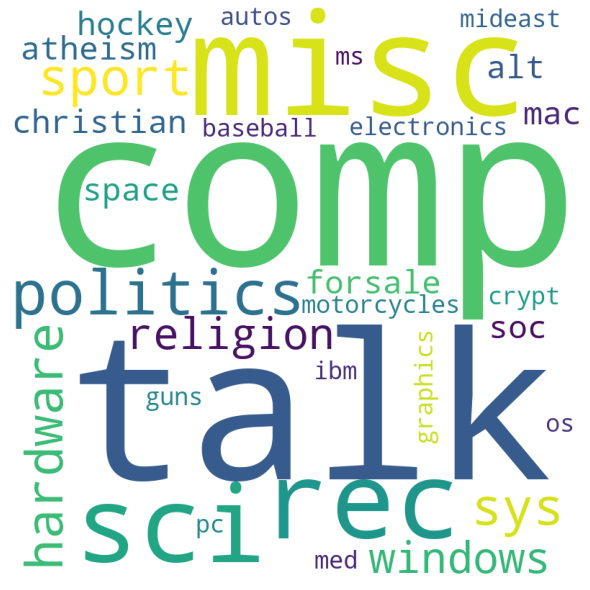

In [48]:
from wordcloud import WordCloud, STOPWORDS 
comment_words = ' '
stopwords = set(STOPWORDS) 
  
# iterate through the csv file 
for val in train.target_names.unique(): 
      
    # typecaste each val to string 
    val = str(val) 
  
    # split the value 
    tokens = val.split() 
      
    # Converts each token into lowercase 
    for i in range(len(tokens)): 
        tokens[i] = tokens[i].lower() 
          
    for words in tokens: 
     comment_words = comment_words + words + ' '
  
  
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                stopwords = stopwords, 
                min_font_size = 10).generate(comment_words) 
  
# plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show() 